In [45]:
print("""
多代理智能客服系统 - 完整实现

本模块实现了一个生产级别的多代理客服系统，包括：
- 智能意图分类和路由
- 专业领域代理（技术支持、订单服务、产品咨询）
- 工具集成（订单查询、产品搜索）
- 服务质量监控
- 人工升级机制
""")


多代理智能客服系统 - 完整实现

本模块实现了一个生产级别的多代理客服系统，包括：
- 智能意图分类和路由
- 专业领域代理（技术支持、订单服务、产品咨询）
- 工具集成（订单查询、产品搜索）
- 服务质量监控
- 人工升级机制



In [46]:
import os
from typing import List, Dict, Any,Optional, TypedDict,Literal,Annotated
from dataclasses import dataclass
from datetime import datetime
import json
from dotenv import load_dotenv


In [47]:
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain.messages import HumanMessage,AIMessage,SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool

In [48]:
from langgraph.graph import StateGraph,START,END

In [49]:
# ==================== JSON 解析辅助函数 ====================

def safe_parse_json(text: str, default: dict = None) -> dict:
    """
    安全地解析JSON文本
    
    处理：
    - Markdown 代码块 (```json ... ```)
    - 前后的空白字符
    - 解析失败时返回默认值
    """
    if default is None:
        default = {}
    
    content = text.strip()
    
    # 移除 Markdown 代码块
    if "```json" in content:
        try:
            content = content.split("```json")[1].split("```")[0]
        except IndexError:
            pass
    elif "```" in content:
        try:
            parts = content.split("```")
            if len(parts) >= 2:
                content = parts[1]
        except IndexError:
            pass
    
    content = content.strip()
    
    try:
        return json.loads(content)
    except json.JSONDecodeError as e:
        print(f"   ⚠️ JSON 解析失败: {e}")
        return default


In [50]:
# 加载环境变量
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY or GROQ_API_KEY == "your_groq_api_key_here":
    raise ValueError(
        "\n请先在 .env 文件中设置有效的 GROQ_API_KEY\n"
        "访问 https://console.groq.com/keys 获取免费密钥"
    )

In [51]:
# 初始化模型
model = init_chat_model("groq:moonshotai/kimi-k2-instruct-0905", api_key=GROQ_API_KEY)


In [52]:
# ==================== 模拟数据库 ====================

MOCK_ORDERS = {
    "ORD001": {
        "status": "已发货",
        "product": "智能手表 Pro",
        "price": 1299,
        "shipping": "顺丰快递",
        "tracking": "SF1234567890",
        "estimated_delivery": "2024-12-20"
    },
    "ORD002": {
        "status": "处理中",
        "product": "无线耳机 Max",
        "price": 899,
        "shipping": "待发货",
        "tracking": None,
        "estimated_delivery": "2024-12-22"
    },
    "ORD003": {
        "status": "已完成",
        "product": "便携充电宝",
        "price": 199,
        "shipping": "已签收",
        "tracking": "YT9876543210",
        "estimated_delivery": "2024-12-15"
    }
}

MOCK_PRODUCTS = {
    "智能手表 Pro": {
        "price": 1299,
        "features": ["心率监测", "GPS定位", "防水50米", "7天续航"],
        "stock": 50,
        "rating": 4.8
    },
    "无线耳机 Max": {
        "price": 899,
        "features": ["主动降噪", "40小时续航", "蓝牙5.3", "通话降噪"],
        "stock": 120,
        "rating": 4.6
    },
    "便携充电宝": {
        "price": 199,
        "features": ["20000mAh", "快充支持", "双USB输出", "LED显示"],
        "stock": 200,
        "rating": 4.5
    },
    "智能音箱": {
        "price": 499,
        "features": ["语音控制", "多房间音频", "智能家居联动", "Hi-Fi音质"],
        "stock": 80,
        "rating": 4.7
    }
}

FAQ_DATABASE = {
    "连接问题": "请尝试以下步骤：1) 重启设备 2) 检查蓝牙是否开启 3) 删除配对记录后重新配对 4) 确保设备电量充足",
    "充电问题": "建议使用原装充电器，检查充电线是否损坏。如果问题持续，可能需要更换电池或送修。",
    "软件更新": "打开设备对应的APP，进入设置-关于-检查更新，按提示操作即可完成更新。",
    "退货政策": "我们支持7天无理由退货，30天内有质量问题可换货。请保留好购买凭证和完整包装。"
}


In [53]:

# ==================== 工具定义 ====================

@tool
def query_order(order_id: str) -> str:
    """查询订单信息

    Args:
        order_id: 订单号，格式如 ORD001
    
    Returns:
        订单详情的JSON字符串
    """
    order = MOCK_ORDERS.get(order_id.upper())
    if order:
        return json.dumps(order, ensure_ascii=False, indent=2)
    return f"未找到订单 {order_id}"

@tool
def track_shipping(tracking_number: str) -> str:
    """查询物流信息

    Args:
        tracking_number: 物流单号
    
    Returns:
        物流状态信息
    """
    # 模拟物流信息
    if tracking_number.startswith("SF"):
        return f"顺丰快递 {tracking_number}: 包裹已到达配送站，预计今日送达"
    elif tracking_number.startswith("YT"):
        return f"圆通快递 {tracking_number}: 已签收"
    return f"未找到物流信息 {tracking_number}"

@tool
def search_product(keyword: str) -> str:
    """搜索产品信息

    Args:
        keyword: 产品关键词
    
    Returns:
        匹配产品的信息
    """
    results = []
    for name, info in MOCK_PRODUCTS.items():
        if keyword.lower() in name.lower():
            results.append({
                "name": name,
                "price": f"¥{info['price']}",
                "features": info['features'],
                "rating": f"{info['rating']}分"
            })
    
    if results:
        return json.dumps(results, ensure_ascii=False, indent=2)
    return f"未找到包含 '{keyword}' 的产品"

@tool
def get_product_recommendations(budget: int, category: str = "全部") -> str:
    """根据预算推荐产品

    Args:
        budget: 预算金额
        category: 产品类别（可选）
    
    Returns:
        推荐产品列表
    """
    recommendations = []
    for name, info in MOCK_PRODUCTS.items():
        if info['price'] <= budget:
            recommendations.append({
                "name": name,
                "price": f"¥{info['price']}",
                "rating": info['rating']
            })
    
    # 按评分排序
    recommendations.sort(key=lambda x: float(x['rating']), reverse=True)
    
    if recommendations:
        return json.dumps(recommendations[:3], ensure_ascii=False, indent=2)
    return f"在预算 ¥{budget} 内暂无推荐产品"

@tool
def search_faq(problem_type: str) -> str:
    """搜索常见问题解答

    Args:
        problem_type: 问题类型关键词
    
    Returns:
        相关FAQ答案
    """
    for key, answer in FAQ_DATABASE.items():
        if problem_type in key or key in problem_type:
            return f"【{key}】\n{answer}"
    return "未找到相关FAQ，建议联系人工客服获取更多帮助。"

In [54]:
# ==================== 状态定义 ====================
class CustomerServiceState(TypedDict):
    '''客服系统状态'''
    user_message: str #用户消息
    chat_history: List[Dict[str,str]] #聊天历史
    intent: str #用户意图
    confidence: float #意图置信度
    agent_response:str #代理回复
    needs_escalation: bool #是否需要升级
    escalation_reason: str #升级原因
    quality_score: float #服务质量评分
    metadata: Dict[str, Any] #其他元数据

In [55]:
# ==================== 代理定义 ====================
class IntentClassifier:
    """意图分类器"""
    
    def __init__(self):
        self.llm = model
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """你是一个意图分类专家。分析用户消息并返回意图分类。

可选意图：
- tech_support: 技术问题、故障排除、使用帮助
- order_service: 订单查询、物流跟踪、退换货
- product_consult: 产品咨询、价格询问、功能介绍
- escalate: 投诉、无法理解、需要人工

返回格式（JSON）：
{{"intent": "意图类型", "confidence": 0.0-1.0, "reason": "分类原因"}}

只返回JSON，不要其他内容。"""),
            ("human", "{message}")
        ])
    
    def classify(self, message: str) -> Dict[str, Any]:
        """分类用户意图"""
        chain = self.prompt | self.llm | StrOutputParser()
        result = chain.invoke({"message": message})
        
        # 使用安全的 JSON 解析
        default_result = {"intent": "escalate", "confidence": 0.5, "reason": "解析失败"}
        parsed = safe_parse_json(result, default_result)
        
        # 确保返回有效的意图
        if "intent" not in parsed:
            return default_result
        return parsed

In [56]:
class TechSupportAgent:
    """技术支持代理"""
    def __init__(self):
        self.llm = model
        self.tools = [search_faq]
        self.system_prompt = """你是一个专业的技术支持工程师。你的职责是：
1. 分析用户遇到的技术问题
2. 提供清晰的故障排除步骤
3. 使用 search_faq 工具查找相关解决方案
4. 如果问题超出能力范围，建议升级到人工支持

回复要求：
- 语气友好专业
- 步骤清晰有序
- 提供多个可能的解决方案"""

        # 创建agent
        self.agent = create_agent(
            model = self.llm,
            tools=self.tools,
            system_prompt=self.system_prompt,
        )
    def handle(self,message:str, chat_history: List = None) -> str:
        """处理技术支持请求"""
        # 不需要再拼接 system_prompt，直接传用户消息
        messages = [{"role": "user", "content": message}]
        result = self.agent.invoke({
            "messages": messages,
        })
        # 提取最终回复
        if result["messages"]:
            return result["messages"][-1].content
        return "抱歉，我暂时无法处理您的问题。建议联系人工客服。"

In [57]:
class OrderServiceAgent:
    """订单服务代理"""
    
    def __init__(self):
        self.llm = model
        self.tools = [query_order, track_shipping]
        
        self.system_prompt = """你是一个专业的订单服务专员。你的职责是：
1. 帮助用户查询订单状态
2. 提供物流跟踪信息
3. 解答退换货相关问题
4. 使用工具获取准确信息

回复要求：
- 信息准确完整
- 主动提供相关信息
- 如果需要订单号，礼貌询问"""
        
        self.agent = create_agent(
            model=self.llm,
            tools=self.tools,
            system_prompt=self.system_prompt
        )
    
    def handle(self, message: str, chat_history: List = None) -> str:
        """处理订单服务请求"""
        messages = [{"role": "user", "content": message}]
        
        result = self.agent.invoke({"messages": messages})
        
        if result["messages"]:
            return result["messages"][-1].content
        return "抱歉，订单查询服务暂时不可用。请稍后再试。"

In [58]:
class ProductConsultAgent:
    """产品咨询代理"""
    
    def __init__(self):
        self.llm = model
        self.tools = [search_product, get_product_recommendations]
        
        self.system_prompt = """你是一个热情的产品顾问。你的职责是：
1. 介绍产品功能和特点
2. 根据用户需求推荐合适的产品
3. 解答价格和库存问题
4. 使用工具获取最新产品信息

回复要求：
- 热情有亲和力
- 突出产品优势
- 根据用户需求推荐
- 不要过度推销"""
        
        self.agent = create_agent(
            model=self.llm,
            tools=self.tools,
            system_prompt=self.system_prompt
        )
    
    def handle(self, message: str, chat_history: List = None) -> str:
        """处理产品咨询请求"""
        messages = [{"role": "user", "content": message}]
        
        result = self.agent.invoke({"messages": messages})
        
        if result["messages"]:
            return result["messages"][-1].content
        return "抱歉，产品信息查询暂时不可用。请稍后再试。"

In [59]:
class QualityChecker:
    """质量检查器"""
    
    def __init__(self):
        self.llm = model
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """你是客服质量检查专家。评估客服回复的质量。

评估维度：
1. 相关性（0-25分）：回复是否针对用户问题
2. 完整性（0-25分）：是否提供了足够的信息
3. 专业性（0-25分）：语言是否专业得体
4. 有用性（0-25分）：是否真正帮助到用户

返回格式（JSON）：
{{"total_score": 0-100, "needs_escalation": true/false, "reason": "评估说明"}}

只返回JSON。"""),
            ("human", """用户问题：{user_message}
客服回复：{agent_response}

请评估：""")
        ])
    
    def check(self, user_message: str, agent_response: str) -> Dict[str, Any]:
        """检查回复质量"""
        chain = self.prompt | self.llm | StrOutputParser()
        result = chain.invoke({
            "user_message": user_message,
            "agent_response": agent_response
        })
        
        # 使用安全的 JSON 解析
        default_result = {"total_score": 60, "needs_escalation": False, "reason": "评估完成"}
        return safe_parse_json(result, default_result)

In [ ]:
# ==================== 客服系统主类 ====================
class CustomerServiceSystem:
    '''多代理客服系统'''
    def __init__(self):
         # 初始化组件
        self.classifier = IntentClassifier()
        self.tech_agent = TechSupportAgent()
        self.order_agent = OrderServiceAgent()
        self.product_agent = ProductConsultAgent()
        self.quality_checker = QualityChecker()
        # 构建工作流图
        self.graph = self._build_graph()
    def _build_graph(self) -> StateGraph:
        '''构建工作流图'''
        
        def classify_intent(state: CustomerServiceState) -> CustomerServiceState:
            """分类用户意图"""
            print("🔍 分析用户意图...")
            result = self.classifier.classify(state["user_message"])
            
            state["intent"] = result.get("intent", "escalate")
            state["confidence"] = result.get("confidence", 0.5)
            
            print(f"   意图: {state['intent']} (置信度: {state['confidence']:.2f})")
            return state
        
        def route_to_agent(state: CustomerServiceState) -> Literal["tech_support", "order_service", "product_consult", "escalate"]:
            """路由到对应代理"""
            intent = state["intent"]
            confidence = state["confidence"]
            # 低置信度直接升级
            if confidence < 0.6:
                return "escalate"
            
            if intent == "tech_support":
                return "tech_support"
            elif intent == "order_service":
                return "order_service"
            elif intent == "product_consult":
                return "product_consult"
            else:
                return "escalate"
        def tech_support_handler(state: CustomerServiceState) -> CustomerServiceState:
            """技术支持处理"""
            print("🔧 技术支持代理处理中...")
            response = self.tech_agent.handle(state["user_message"])
            state["agent_response"] = response
            return state
        
        def order_service_handler(state: CustomerServiceState) -> CustomerServiceState:
            """订单服务处理"""
            print("📦 订单服务代理处理中...")
            response = self.order_agent.handle(state["user_message"])
            state["agent_response"] = response
            return state
        
        def product_consult_handler(state: CustomerServiceState) -> CustomerServiceState:
            """产品咨询处理"""
            print("🛍️ 产品咨询代理处理中...")
            response = self.product_agent.handle(state["user_message"])
            state["agent_response"] = response
            return state
        def escalate_handler(state: CustomerServiceState) -> CustomerServiceState:
            """升级处理"""
            print("👤 升级到人工客服...")
            state["needs_escalation"] = True
            state["escalation_reason"] = "意图识别置信度低或用户要求人工服务"
            state["agent_response"] = """非常抱歉，您的问题需要人工客服来处理。

我已经为您转接人工客服，请稍候...

在等待期间，您也可以：
1. 拨打客服热线：400-xxx-xxxx
2. 发送邮件至：support@example.com
3. 工作日 9:00-18:00 在线客服响应更快

感谢您的耐心等待！"""
            return state
        def quality_check(state: CustomerServiceState) -> CustomerServiceState:
            """质量检查"""
            print("✅ 执行质量检查...")
            result = self.quality_checker.check(
                state["user_message"],
                state["agent_response"]
            )
            
            state["quality_score"] = result.get("total_score", 0) / 100
            
            # 质量太低需要升级
            if result.get("needs_escalation", False) or state["quality_score"] < 0.6:
                state["needs_escalation"] = True
                state["escalation_reason"] = result.get("reason", "质量检查未通过")
            
            print(f"   质量评分: {state['quality_score']:.2f}")
            return state
        def should_escalate(state: CustomerServiceState) -> Literal["escalate_final", "respond"]:
            """判断是否需要升级"""
            if state.get("needs_escalation", False):
                return "escalate_final"
            return "respond"
        def final_escalate(state: CustomerServiceState) -> CustomerServiceState:
            """最终升级处理"""
            # 保留原始回复但添加升级提示
            original_response = state["agent_response"]
            state["agent_response"] = f"""{original_response}

---
⚠️ 系统提示：由于此问题可能需要更专业的处理，我们建议您联系人工客服以获得更好的服务。"""
            return state
        def respond(state: CustomerServiceState) -> CustomerServiceState:
            """最终响应"""
            return state
            # 构建图
        graph = StateGraph(CustomerServiceState)

        # 添加节点
        graph.add_node("classify", classify_intent)
        graph.add_node("tech_support", tech_support_handler)
        graph.add_node("order_service", order_service_handler)
        graph.add_node("product_consult", product_consult_handler)
        graph.add_node("escalate", escalate_handler)
        graph.add_node("quality_check", quality_check)
        graph.add_node("escalate_final", final_escalate)
        graph.add_node("respond", respond)
        # 添加边
        graph.add_edge(START, "classify")
        
        # 条件路由
        graph.add_conditional_edges(
            "classify",
            route_to_agent,
            {
                "tech_support": "tech_support",
                "order_service": "order_service",
                "product_consult": "product_consult",
                "escalate": "escalate"
            }
        )
        
        # 代理处理后进行质量检查
        graph.add_edge("tech_support", "quality_check")
        graph.add_edge("order_service", "quality_check")
        graph.add_edge("product_consult", "quality_check")
        graph.add_edge("escalate", END)
        
        # 质量检查后的条件路由
        graph.add_conditional_edges(
            "quality_check",
            should_escalate,
            {
                "escalate_final": "escalate_final",
                "respond": "respond"
            }
        )
        
        graph.add_edge("escalate_final", END)
        graph.add_edge("respond", END)
        app = graph.compile()
        return app
    def handle_message(self, message: str, chat_history: List[Dict] = None) -> Dict[str, Any]:
        """处理用户消息"""
        print(f"\n{'='*60}")
        print(f"💬 用户: {message}")
        print('='*60)
        
        initial_state = {
            "user_message": message,
            "chat_history": chat_history or [],
            "intent": "",
            "confidence": 0.0,
            "agent_response": "",
            "needs_escalation": False,
            "escalation_reason": "",
            "quality_score": 0.0,
            "metadata": {"timestamp": datetime.now().isoformat()}
        }
        
        result = self.graph.invoke(initial_state)
        
        return {
            "response": result["agent_response"],
            "intent": result["intent"],
            "confidence": result["confidence"],
            "quality_score": result["quality_score"],
            "escalated": result["needs_escalation"]
        }    

In [61]:
"""演示多代理客服系统"""

print("=" * 60)
print("🤖 多代理智能客服系统演示")
print("=" * 60)

# 初始化系统
print("\n📦 初始化客服系统...")
system = CustomerServiceSystem()
print("✅ 系统初始化完成！")

🤖 多代理智能客服系统演示

📦 初始化客服系统...
✅ 系统初始化完成！


In [62]:
# 测试场景
test_cases = [
    # 技术支持场景
    {
        "category": "技术支持",
        "messages": [
            "我的蓝牙耳机连接不上手机怎么办？",
            "手表充电很慢，是不是坏了？"
        ]
    },
    # 订单服务场景
    {
        "category": "订单服务",
        "messages": [
            "帮我查一下订单 ORD001 的物流状态",
            "我的订单什么时候能到？订单号是 ORD002"
        ]
    },
    # 产品咨询场景
    {
        "category": "产品咨询",
        "messages": [
            "你们有什么智能手表推荐吗？预算1500左右",
            "无线耳机有什么功能？"
        ]
    },
    # 升级场景
    {
        "category": "人工升级",
        "messages": [
            "我要投诉！这是第三次出问题了！",
            "我想和你们经理谈谈"
        ]
    }
]

In [ ]:
# 运行测试
for test in test_cases:
    print(f"\n{'='*60}")
    print(f"📝 测试类别: {test['category']}")
    print('='*60)
    
    for message in test["messages"]:
        result = system.handle_message(message)
        
        print("\n🤖 客服回复:")
        print(f"{result['response']}")
        print("\n📊 处理信息:")
        print(f"   - 意图: {result['intent']}")
        print(f"   - 置信度: {result['confidence']:.2f}")
        print(f"   - 质量评分: {result['quality_score']:.2f}")
        print(f"   - 是否升级: {'是' if result['escalated'] else '否'}")
        print("-" * 60)



📝 测试类别: 技术支持

💬 用户: 我的蓝牙耳机连接不上手机怎么办？
🔍 分析用户意图...
   意图: tech_support (置信度: 0.95)
🔧 技术支持代理处理中...
✅ 执行质量检查...
   质量评分: 0.95

🤖 客服回复:
{'response': '虽然系统没有找到具体的FAQ，但作为一名技术支持工程师，我可以为您提供一些详细的故障排除步骤：\n\n## 🔍 **基础检查步骤**\n\n1. **确认耳机电量充足**\n   - 将耳机放入充电盒充电至少30分钟\n   - 确保充电盒也有足够电量\n\n2. **检查耳机状态**\n   - 确认耳机已退出充电盒（部分耳机需要取出才能配对）\n   - 查看耳机指示灯是否正常闪烁\n\n## 📱 **手机端操作**\n\n3. **重启蓝牙功能**\n   - 关闭手机蓝牙，等待10秒，重新开启\n   - 在蓝牙设置中"忽略设备"或"取消配对"原有记录\n\n4. **重启手机**\n   - 完全关机重启，清除临时软件故障\n\n## 🎧 **耳机重置操作**\n\n5. **将耳机恢复出厂设置**\n   - 长按耳机功能键10-15秒（具体参考说明书）\n   - 直到耳机指示灯快速闪烁或变色\n\n6. **重新配对**\n   - 确保耳机处于配对模式（通常需要长按功能键）\n   - 在手机蓝牙列表中查找新设备\n\n## 🔧 **进阶解决方案**\n\n7. **检查兼容性**\n   - 确认手机支持蓝牙4.0或更高版本\n   - 查看耳机说明书确认支持的蓝牙版本\n\n8. **清除蓝牙缓存**（安卓手机）\n   - 设置 > 应用管理 > 显示系统进程 > 蓝牙 > 存储 > 清除缓存\n\n如果以上步骤都无法解决问题，建议您：\n- 联系耳机厂商客服\n- 到专业维修点检测硬件问题\n\n需要我详细说明任何步骤吗？', 'intent': 'tech_support', 'confidence': 0.95, 'quality_score': 0.95, 'escalated': False}

📊 处理信息:
   - 意图: tech_support
   - 置信度: 0.95
   - 质量评分: 0.95
   - 是否升级: 否
--

In [64]:
# 交互式演示
print("\n" + "=" * 60)
print("💬 交互式对话演示")
print("=" * 60)
print("提示: 输入 'quit' 退出")

chat_history = []

while True:
    user_input = input("\n👤 您: ").strip()
    
    if user_input.lower() == 'quit':
        print("\n感谢使用智能客服系统，再见！👋")
        break
    
    if not user_input:
        continue
    
    result = system.handle_message(user_input, chat_history)
    print(f"\n🤖 客服: {result['response']}")
    
    # 更新对话历史
    chat_history.append({"role": "user", "content": user_input})
    chat_history.append({"role": "assistant", "content": result['response']})


💬 交互式对话演示
提示: 输入 'quit' 退出

💬 用户: 你是谁？
🔍 分析用户意图...
   意图: product_consult (置信度: 0.90)
🛍️ 产品咨询代理处理中...
✅ 执行质量检查...
   质量评分: 0.90

🤖 客服: 嗨，我是你的专属产品顾问小智！☺️ 很高兴认识你～  
无论你想找什么产品、对比功能、查价格还是看库存，只要告诉我需求，我就能立刻为你推荐最合适的选择。有什么想了解的，尽管开口吧！

💬 用户: 厉害啊
🔍 分析用户意图...
   意图: escalate (置信度: 0.70)
👤 升级到人工客服...

🤖 客服: 非常抱歉，您的问题需要人工客服来处理。

我已经为您转接人工客服，请稍候...

在等待期间，您也可以：
1. 拨打客服热线：400-xxx-xxxx
2. 发送邮件至：support@example.com
3. 工作日 9:00-18:00 在线客服响应更快

感谢您的耐心等待！

感谢使用智能客服系统，再见！👋


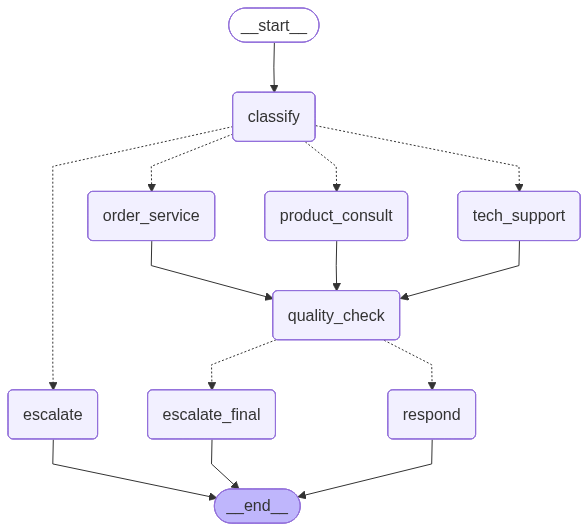

In [66]:
system.graph